# CSW nets as regression problem

In [1]:
import torch as tr
import numpy as np
from CSW import *
from scipy.spatial import distance
import itertools

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# train loop

In [27]:
# task
taskL = [CSWTask(1),CSWTask(0)]

# eval params
eval_pathL = [
  [0,11,1,4,5],       
    ]
eval_ypathL = [
  [11,1,4,5,7],       
    ]

xeval = tr.tensor(taskL[0].format_Xeval(eval_pathL))
yeval = tr.tensor(taskL[0].format_Xeval(eval_ypathL))


In [161]:
# task specs
block_len0 = 40
task_type = 'regression'
lossop = tr.nn.MSELoss()
# nnets
nnets = 10
## params
envsize = 12
stsize = 35
learn_rate = 0.01
neps = 200

## train setup
Emat = tr.Tensor(np.random.normal(0,1,[12,envsize]))

# eval array
eval_tsteps = 2 # layer2 and layer3
num_eval_paths = len(eval_pathL) 
acc = -np.ones([nnets,neps,eval_tsteps]) # 2 tsteps (layer2 and layer3)
yeval = -np.ones([nnets,num_eval_paths,neps,eval_tsteps,envsize])
lossA = -np.ones([nnets,neps])


## loop over seeds
for seed in range(nnets):
  # init net
  net = CSWNetReg(envsize,stsize,seed)
  optiop = tr.optim.Adam(net.parameters(), lr=learn_rate)
  
  ## train loop
  task_int = 0
  block_len = block_len0 
  for ep in range(neps):
    if ep >= 160:
      block_len = 1
    # select graph
    if ep%block_len==0:
      task_int = (task_int+1)%2
      task = taskL[task_int]
      filler_id = 10+task_int 
      
    ## forward prop  
    path = task.sample_path()
    xtrain,ytrain = task.dataset_onestory_with_marker(path=path,filler_id=filler_id,depth=1)
    print(xtrain)
    assert False
    xtrain,ytrain = Emat[xtrain],Emat[ytrain]
    yh = net(xtrain) # (time,smunits)
    yt = ytrain.detach().numpy().squeeze()
    
    ## compute accuracy
    acc[seed,ep,0] = distance.cosine(yh[2:3].detach().numpy(),yt[2:3])
    acc[seed,ep,1] = distance.cosine(yh[3:4].detach().numpy(),yt[3:4])

    ## eval
    for path_idx,xev in enumerate(xeval):
      xev = Emat[xev]
      yhev = net(xev).detach().numpy()
      for tstep_idx,yhev_t in enumerate(yhev[2:4]):
        yeval[seed,path_idx,ep,tstep_idx] = distance.cdist([yhev_t],Emat,'euclidean')      
        
    ## train
    loss = 0
    for tstep in range(len(xtrain)):
      loss = lossop(yh[tstep].unsqueeze(0),ytrain[tstep])
      optiop.zero_grad()
      loss.backward(retain_graph=True)
      optiop.step()
    lossA[seed,ep] = loss



tensor([[ 0],
        [11],
        [ 1],
        [ 4],
        [ 5]])


AssertionError: 

In [73]:
yeval.shape # nets,paths,neps,tsteps,envstate

(10, 1, 200, 2, 12)

# regression sweep 2 plt

In [9]:
def load_yeval(stsize,lr):
  L = []
  for block in [1,40]:
    fpath = "yeval-block-%i_lr-%.3f_stsize-%i.npy"% (block,lr,stsize)
    a = np.load('matchSEM/regression_sweep2/model_data/'+fpath)
    L.append(a)
  return np.array(L)

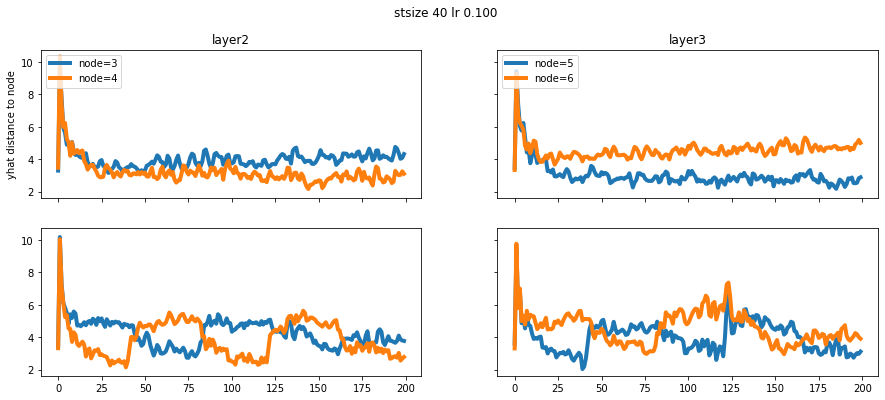

In [10]:
stsizeL = [20,25,30,35,40]
lrL = [0.005,0.01,0.05,0.1]

for stsize,lr in itertools.product(stsizeL,lrL):
  yeval = load_yeval(stsize,lr)

  path_idx = 0
  nodesL = [(3,4),(5,6)]
  plt.close('all')
  figure,axarr = plt.subplots(2,2,figsize=(15,6),sharey=True,sharex=True)

  plt.suptitle('stsize %i lr %.3f'%(stsize,lr))
  for block_idx in range(2):
    yevalM = yeval[block_idx,:,path_idx].mean(0)
    yevalS = yeval[block_idx,:,path_idx].std(0)/np.sqrt(yeval.shape[2])
    for layer_idx in range(2):
      for node_idx in range(2):
          eval_node = nodesL[layer_idx][node_idx]
          yeval_plt = yevalM[:,layer_idx,eval_node]
          ax = axarr[block_idx,layer_idx]
          ax.plot(yeval_plt,lw=4,label='node=%i'%(eval_node))
          
  
  ax = axarr[0,0]
  ax.legend(loc=2)
  ax.set_title('layer2')
  ax.set_ylabel('yhat distance to node')
  ax = axarr[0,1]
  ax.legend(loc=2)
  ax.set_title('layer3')
  plt.savefig('matchSEM/regression_sweep2/figures/yeval_lr-%.3f_stsize-%i.png'%(lr,stsize))

# plot regression sweep1

In [11]:
def load_acc(stsize,lr):
  L = []
  for block in [1,40]:
    fpath = "acc-block-%i_lr-%.3f_stsize-%i.npy"% (block,lr,stsize)
    a = np.load('matchSEM/regression_sweep2/model_data/'+fpath)
    L.append(a)
  return np.array(L)



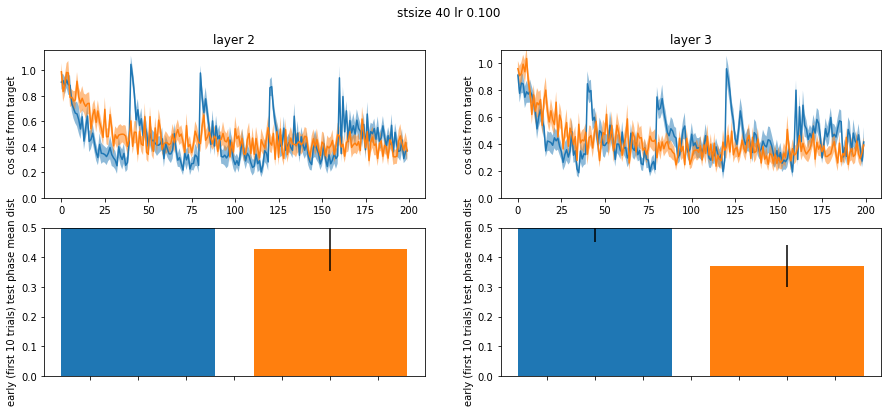

In [12]:
stsizeL = [20,25,30,35,40]
lrL = [0.005,0.01,0.05,0.1]

for stsize,lr in itertools.product(stsizeL,lrL):
  acc1,acc40 = load_acc(stsize,lr)
  plt.close('all')
  figure,axarr = plt.subplots(2,2,figsize=(15,6))
  plt.suptitle('stsize %i lr %.3f'%(stsize,lr))
  for tstep in [0,1]:
    for idx,acc in enumerate([acc40,acc1]):
      acc = acc[:,:,tstep]
      ax = axarr[0,tstep]
      M = acc.mean(0)
      S = acc.std(0)/np.sqrt(len(acc))
      ax.plot(M)
      ax.fill_between(range(200),M-S,M+S,alpha=0.5)
      ax.set_ylabel('cos dist from target')
      ax.set_ylim(0)
      ax = axarr[1,tstep]
      ax.bar([idx],M[-40:-30].mean(),yerr=S.mean())
      ax.set_ylabel('early (first 10 trials) test phase mean dist')
      ax.set_xticklabels([])
      ax.set_ylim(0,0.5)

  axarr[0,0].set_title('layer 2')
  axarr[0,1].set_title('layer 3')
  plt.savefig('matchSEM/regression_sweep2/figures/acc_lr-%.3f_stsize-%i.png'%(lr,stsize))
